In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [12]:
df = pd.read_csv('travel_insurance.csv')


In [13]:
df.head()

,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,31,Government Sector,Yes,400000,6,1,No,No,0
1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1
3,28,Private Sector/Self Employed,Yes,700000,3,1,No,No,0
4,28,Private Sector/Self Employed,Yes,700000,8,1,Yes,No,0


In [14]:
df['Age'] = pd.cut(df['Age'], bins=5, labels=[0,1,2,3,4])

In [15]:
df['AnnualIncome'] = pd.cut(df['AnnualIncome'], bins=10, labels=[0,1,2,3,4,5,6,7,8,9])

In [16]:
one_hot_columns = ['Employment Type', 'FrequentFlyer', 'EverTravelledAbroad', 'GraduateOrNot']
ordinal_columns = ['Age', 'AnnualIncome'] #Family Members are already ordinal
target_column = 'TravelInsurance'


In [17]:
one_hot_df = pd.get_dummies(df[one_hot_columns])
ordinal_df = df[ordinal_columns]

encoded_df = pd.concat([ordinal_df, one_hot_df], axis=1)
encoded_df.head()

,Age,AnnualIncome,Employment Type_Government Sector,Employment Type_Private Sector/Self Employed,FrequentFlyer_No,FrequentFlyer_Yes,EverTravelledAbroad_No,EverTravelledAbroad_Yes,GraduateOrNot_No,GraduateOrNot_Yes
0,2,0,1,0,1,0,1,0,0,1
1,2,6,0,1,1,0,1,0,0,1
2,4,1,0,1,1,0,1,0,0,1
3,1,2,0,1,1,0,1,0,0,1
4,1,2,0,1,0,1,1,0,0,1


In [18]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df, df[target_column], test_size=0.2, random_state=42)

# Generate a parameter grid for tree hyperparameters
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

# Instantiate a Decision Tree classifier: tree and gridsearch
tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, param_grid, cv=5)

# Fit it to the training data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))



Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best score is 0.7841537210086702


Accuracy on training set: 0.784
Accuracy on test set: 0.799
Accuracy on test set: 0.799


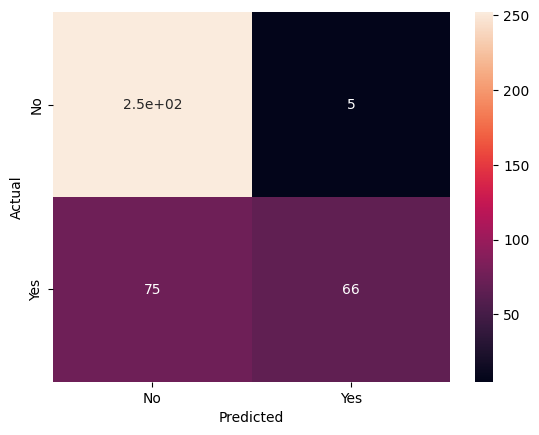

              precision    recall  f1-score   support

           0       0.77      0.98      0.86       257
           1       0.93      0.47      0.62       141

    accuracy                           0.80       398
   macro avg       0.85      0.72      0.74       398
weighted avg       0.83      0.80      0.78       398



In [19]:
# Print the accuracy from the testing data.
y_pred = tree_cv.predict(X_test)
print("Accuracy on training set: {:.3f}".format(tree_cv.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree_cv.score(X_test, y_test)))
print("Accuracy on test set: {:.3f}".format(accuracy_score(y_test, y_pred)))

# Print the confusion matrix using seaborn with true positve and false positive labels
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred))

Feature importances: [1.27942427e-01 8.06471468e-01 0.00000000e+00 0.00000000e+00
 7.65538878e-05 1.59214360e-03 0.00000000e+00 5.91842383e-02
 0.00000000e+00 4.73316901e-03]


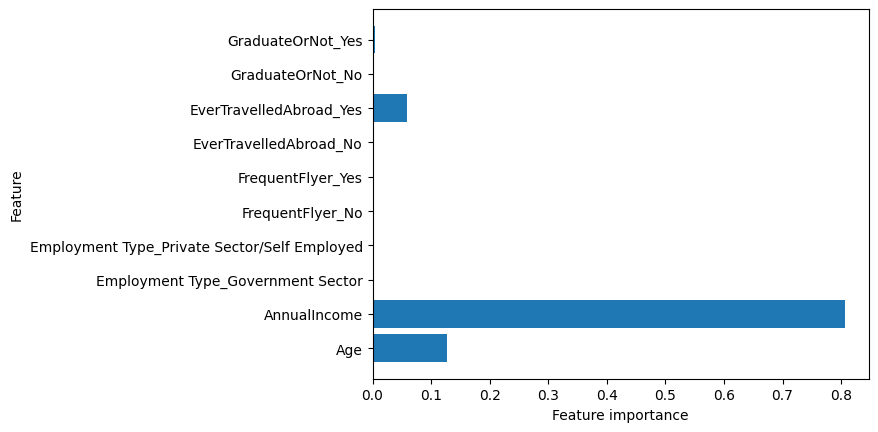

In [25]:
# Print the feature importances from the tree and create a visualization

print("Feature importances: {}".format(tree_cv.best_estimator_.feature_importances_))

n_features = encoded_df.shape[1]
plt.barh(range(n_features), tree_cv.best_estimator_.feature_importances_, align='center')
plt.yticks(np.arange(n_features), encoded_df.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

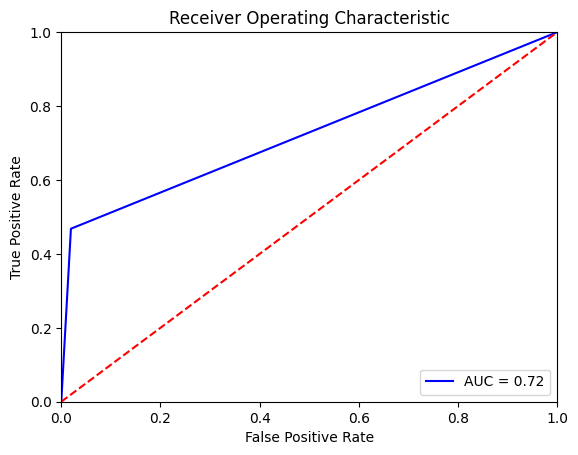

In [21]:
# plot the ROC Curve
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

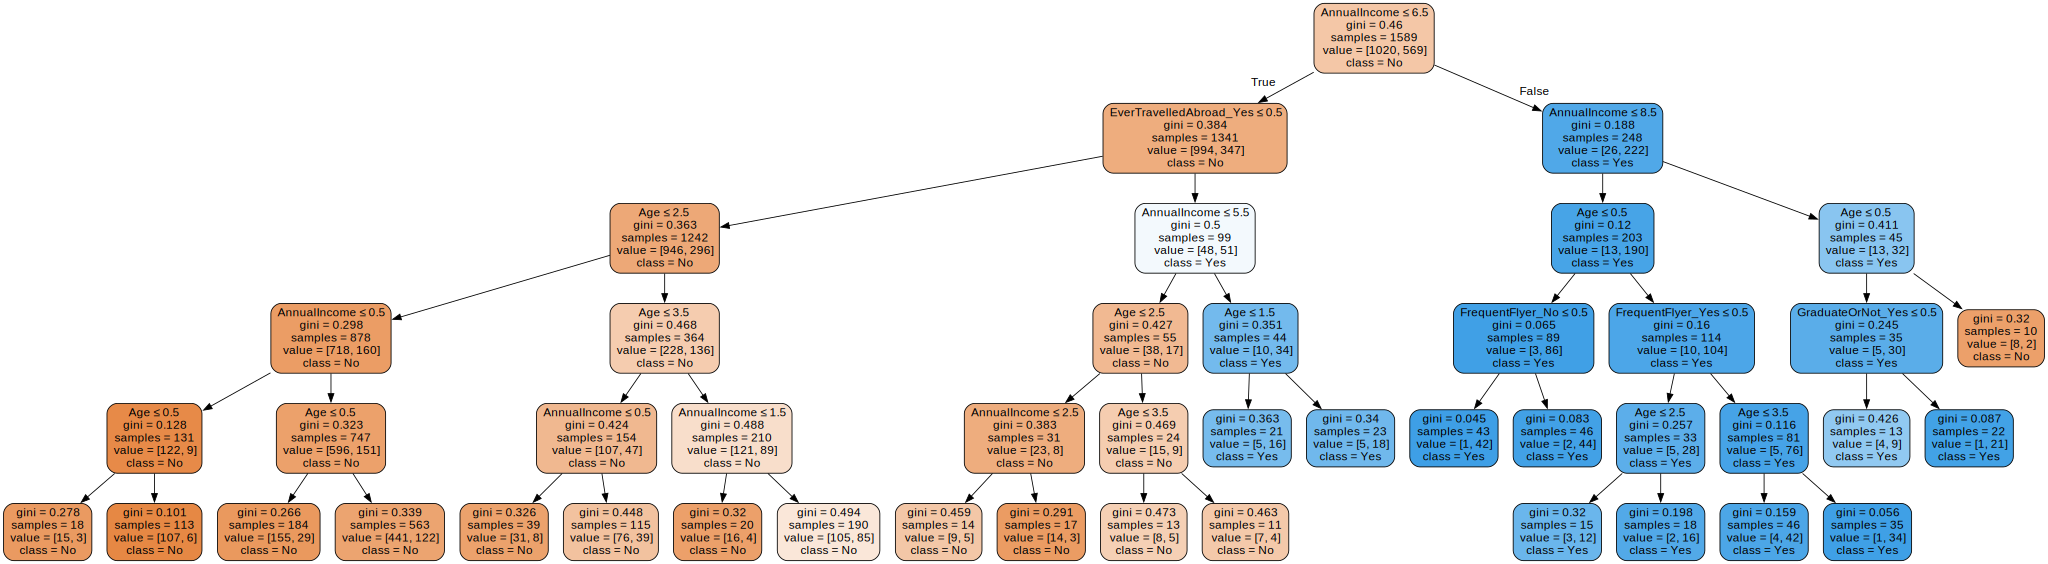

In [22]:
#Create a visualization of the decision tree
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(tree_cv.best_estimator_, out_file=None, 
                           feature_names=encoded_df.columns,  
                           class_names=['No', 'Yes'],  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

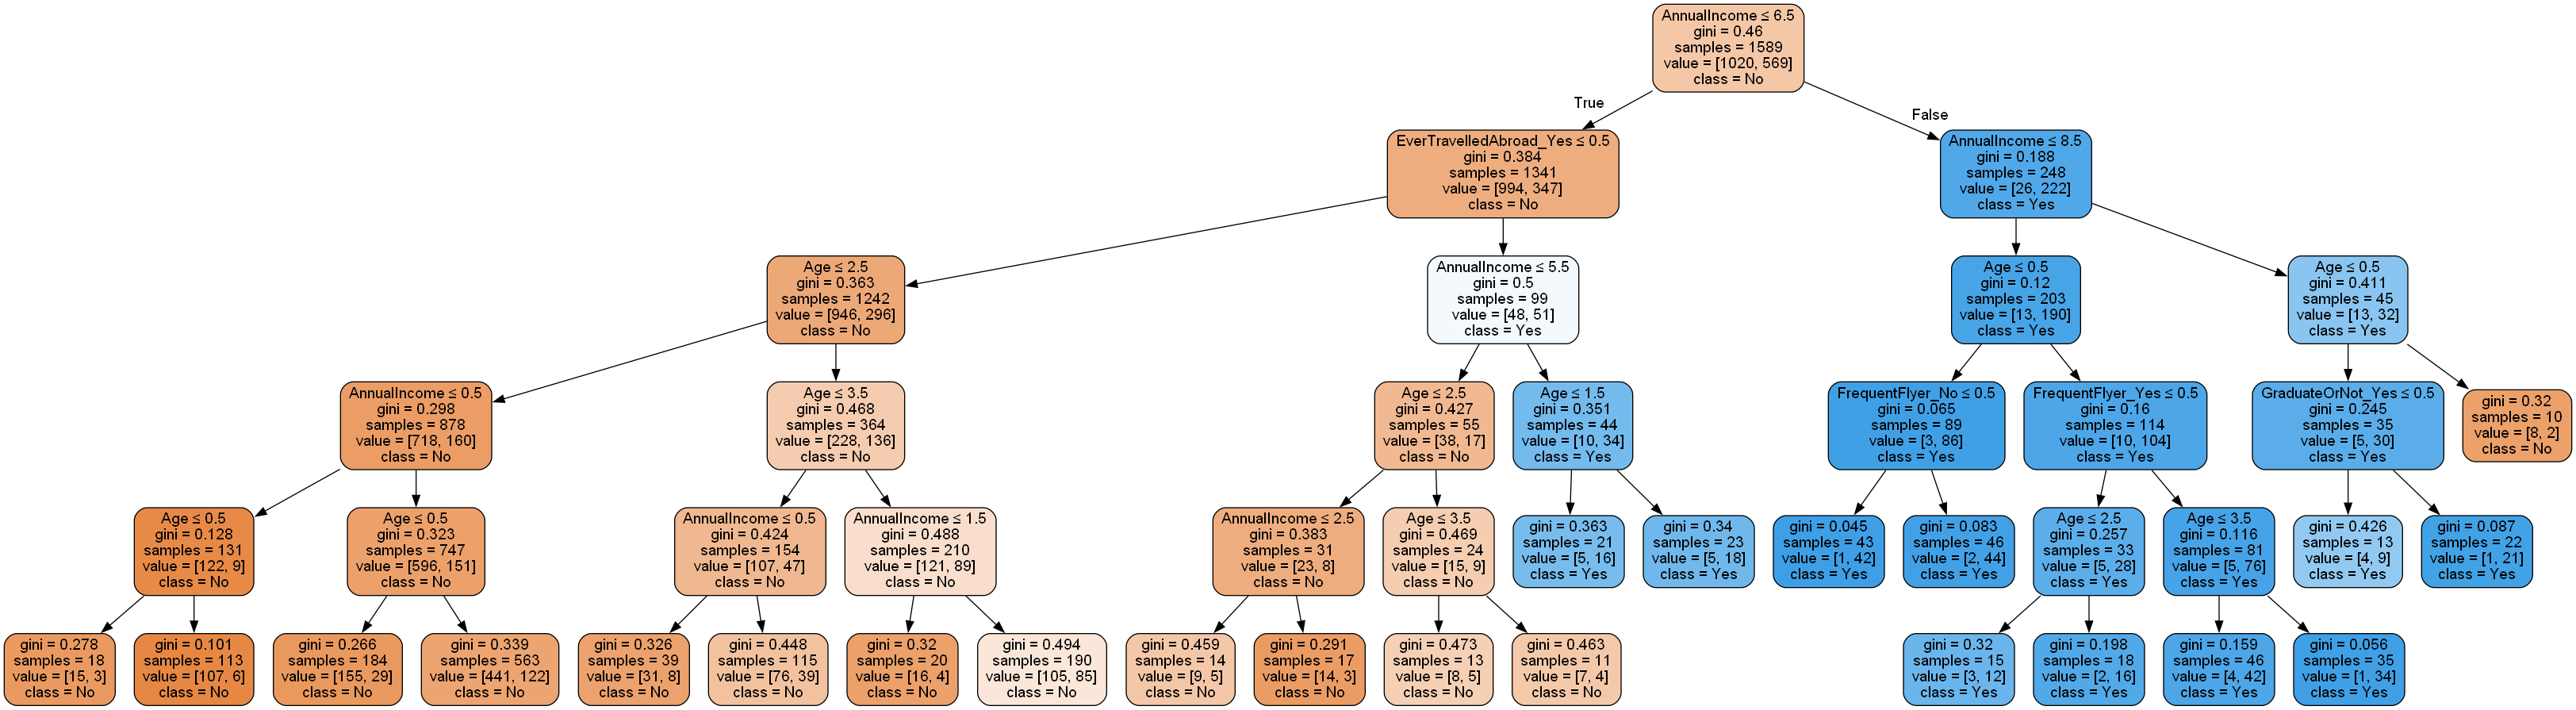

In [24]:
# Show the graphviz image in the notebook
from IPython.display import Image
Image(graphviz.Source(dot_data).pipe(format='png'))